In [1]:
# -*- coding: utf-8 -*-
import sys
print(sys.version)
from pytrack_analysis.profile import *
from pytrack_analysis.database import *
from pytrack_analysis.logger import Logger
import pytrack_analysis.preprocessing as prp
from pytrack_analysis import Kinematics
from pytrack_analysis import Statistics
from pytrack_analysis import Multibench

3.6.2 (v3.6.2:5fd33b5, Jul  8 2017, 04:57:36) [MSC v.1900 64 bit (AMD64)]
E:/Dennis/Google Drive/PhD Project/Tracking Analysis/profile\profile.yaml VERO-PC Windows_NT


In [2]:
### Setting up a profile

# import os module to interact with filesystem
import os
# get filename of this script
thisscript = "Notebook Fig. 1"
# get profile for project 'Vero eLife 2016' as user 'degoldschmidt'
profile = get_profile('Notebook - Vero eLife 2016', 'degoldschmidt', script=thisscript)
# show the profile
show_profile(profile)

Loaded [PROJECT] Notebook - Vero eLife 2016

$PROJECTS:
- Vero eLife 2016
- Notebook - Vero eLife 2016
$USERS:
- degoldschmidt

Notebook - Vero eLife 2016:
  created: '2017-08-11 11:37:03'
  last active: '2017-08-29 16:22:09'
  systems:

    VERO-PC:
      database: E:/Dennis/Google Drive/PhD Project/Archive/VERO/vero_elife_2016/vero_elife_2016.yaml
      log: E:/Dennis/Google Drive/PhD Project/Archive/VERO/vero_elife_2016_processing\main.log
      os: Windows_NT
      output: E:/Dennis/Google Drive/PhD Project/Archive/VERO/vero_elife_2016_processing
      plot: E:/Dennis/Google Drive/PhD Project/Archive/VERO/vero_elife_2016_processing\plots
      python: 3.6.2 (v3.6.2:5fd33b5, Jul  8 2017, 04:57:36) [MSC v.1900 64 bit (AMD64)]
      videos: E:/Dennis/Google Drive/PhD Project/Archive/VERO/Example Videos
  users:
  - degoldschmidt
Vero eLife 2016:
  created: '2017-07-14 20:28:00'
  last active: '2017-08-29 12:58:19'
  systems:
    MacBook-Pro-3.local_degoldschmidt:
      database: /User

In [3]:
# get database from file
db = Database(get_db(profile), in_pynb=True)

STARTING DATA INTEGRITY TEST...
-------------------------------
CHECKING DATABASE...			[O.K.]
CHECKING METAFILES...			[O.K.]
CHECKING DATAFILES...			[O.K.]
CHECKING TIMESTAMPS...			[O.K.]


In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(color_codes=True) 
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("ticks")

def plot_2d(_data, title="", lims=[]):
    fscale = 10
    if len(_data) == 2:
        fig, axes = plt.subplots(1, 2, figsize=(2*fscale,fscale))
    elif len(_data) == 1:
        fig, sax = plt.subplots(1, figsize=(fscale,fscale))
        axes = [sax]
    for i, ax in enumerate(axes):
        data = _data[i]
        if len(lims) == 2:
            ax.plot(data.loc[lims[0]:lims[1],'head_x'], data.loc[lims[0]:lims[1],'head_y'], 'k-', lw=1)
        else:
            ax.plot(data.loc[:,'head_x'], data.loc[:,'head_y'], 'k-', lw=1)
        ax.axis("equal")
        ax.axis("off")
        ax.set_title(title+":", fontsize=24, fontweight='bold', loc='left')
    return fig, axes

def plot_patches(db, sessions=[], axes=[]):
    ### add food spots
    # colors (1: orange 2: blue, 3: white)
    patch_color = {1: '#ffc04c', 2: '#4c8bff', 3: '#ffffff'}
    for i, ax in enumerate(axes):
        # food patch positions (x, y) matrix
        patch_positions = np.array(db.session(sessions[i]).PatchPositions)*db.session(sessions[i]).px2mm
        # food patch substrate type (1: yeast, 2: sucrose, 3: center/empty)
        patch_type = db.session(sessions[i]).SubstrateType
        # food patch radius
        patch_radius = db.session(sessions[i]).patch_radius * db.session(sessions[i]).px2mm
        # go through all patches
        for j, pos in enumerate(patch_positions):
            # get color for given patch
            c = patch_color[patch_type[j]]
            # define circle at position "pos" with radius "patch_radius"
            circle = plt.Circle(pos, patch_radius, color=c, alpha=0.5, zorder=5)
            # add circle to axis artist (draws the circle)
            ax.add_artist(circle)
            if j == 11:
                print(pos/db.session(sessions[i]).px2mm)
                print(patch_radius/db.session(sessions[i]).px2mm)
                circle = plt.Circle(pos, 2.5, edgecolor="#aaaaaa", fill=False, ls=(0,(4,4)), lw=2)
                ax.add_artist(circle)
                circle = plt.Circle(pos, 5., edgecolor="#aaaaaa", fill=False, ls=(0,(4,4)), lw=1)
                ax.add_artist(circle)
        ax.set_xlim([patch_positions[11][0]-5.,patch_positions[11][0]+5.])
        ax.set_ylim([patch_positions[11][1]-5.,patch_positions[11][1]+5.])
    return axes

In [5]:
this_session = db.session('CANS_040')
# load raw data and meta data
raw_data, meta_data = this_session.load()
## STEP 1: NaN removal + interpolation + px-to-mm conversion
clean_data = prp.interpolate(raw_data)
clean_data = prp.to_mm(clean_data, meta_data.px2mm)

[-121.2395   34.3073]
9.6529


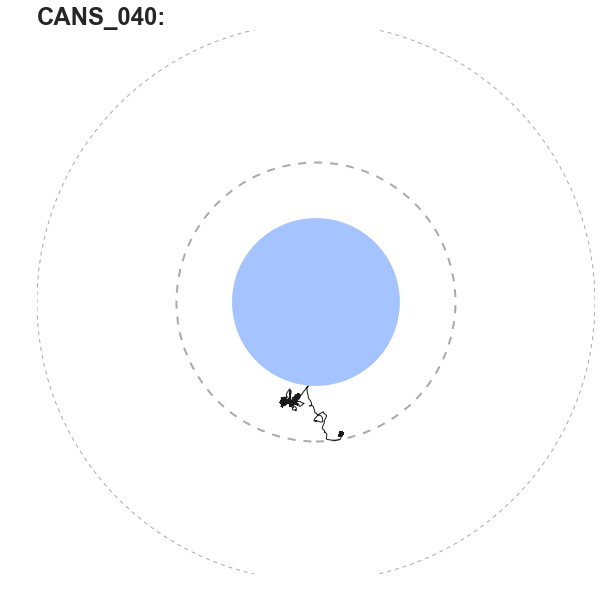

In [6]:
# plot 2d trajectory
fig, axes = plot_2d([clean_data], title=this_session.name, lims=[300000, 350000])
axes = plot_patches(db, sessions=[this_session.name], axes=axes)

In [7]:
import os
from subprocess import run, check_call
import shutil
import shlex

### specifics
start_secs = 300000 / this_session.framerate ## secs
len_secs = 20 ## secs

patchx = -121.2395   
patchy = 34.3073
size = 100
newx = patchx + 478/2 - size/2
newy = -patchy + 478/2 - size/2



def encode(file, start, length):
    outfile = vidfile.split(".")[0] + ".mp4" ## mp4 file
    command = "ffmpeg -ss {} -i {} -t {} -c:v libx264 -crf 19 -preset slow -c:a aac -b:a 192k -ac 2 -y {}".format(start, file.replace("\\", "\\\\"), length, outfile.replace("\\", "\\\\"))
    run(shlex.split(command), shell=True)
    return outfile

def crop(file, size = ("in_w", "in_h"), pos=("0", "0")):
    outfile = file.split(".")[0] +"_crop."+ file.split(".")[1]
    command = "ffmpeg -y -i {} -filter:v 'crop={}:{}:{}:{}' -c:a copy {}".format(file.replace("\\", "\\\\"), size[0], size[1], pos[0], pos[1], outfile.replace("\\", "\\\\"))
    run(shlex.split(command), shell=True)
    return outfile
    
### Defining old folder/file location
vidfile = this_session.Videofilename.split(".")[0] + "P0WT-CantonS." + this_session.Videofilename.split(".")[1]
path_to_videos = "F:\\Videos\\Exp 0003\\"
old_fullpath = os.path.join(path_to_videos, vidfile)
print(old_fullpath)

### Copying to new temp. location
shutil.copy(old_fullpath, os.getcwd())
new_fullpath = os.path.join(os.getcwd(), vidfile)
print("Copied", old_fullpath, "to", new_fullpath)

### encoding and cropping
processed_files = []
processed_files.append(encode(new_fullpath, start_secs, len_secs))
print("encoded:", processed_files[-1])
processed_files.append(crop(processed_files[-1], ("in_h","in_h"), (922,0)))
print("cropped:", processed_files[-1])
processed_files.append(crop(processed_files[-1], (size, size), (newx, newy)))
print("cropped:", processed_files[-1])

for files in processed_files[:-1]:
    os.remove(files)
    print("Removed", files)
os.remove(os.path.join(os.getcwd(), vidfile))
print("Removed",os.path.join(os.getcwd(), vidfile))

F:\Videos\Exp 0003\0003A02R01Cam03P0WT-CantonS.avi
Copied F:\Videos\Exp 0003\0003A02R01Cam03P0WT-CantonS.avi to E:\Dennis\GitHub\pytrack-analysis\notebooks\0003A02R01Cam03P0WT-CantonS.avi
encoded: 0003A02R01Cam03P0WT-CantonS.mp4
cropped: 0003A02R01Cam03P0WT-CantonS_crop.mp4
cropped: 0003A02R01Cam03P0WT-CantonS_crop_crop.mp4
Removed 0003A02R01Cam03P0WT-CantonS.mp4
Removed 0003A02R01Cam03P0WT-CantonS_crop.mp4
Removed E:\Dennis\GitHub\pytrack-analysis\notebooks\0003A02R01Cam03P0WT-CantonS.avi


In [8]:
from IPython.display import HTML

HTML("""
<video width="478" height="478" controls>
  <source src="./0003A02R01Cam03P0WT-CantonS_crop_crop.mp4" type="video/mp4">
</video>
""")

In [12]:
kinematics = Kinematics(db)
smoothed_data, distance_patch, speeds, angular_heading, angular_speed, etho_vector, visits = kinematics.run(this_session, _ALL=True)

<class 'pytrack_analysis.database.Session'>


In [13]:
def plot_etho(_data, lims=[]):
    [start, end] = lims
    dt = 0.02
    ## arange time as a vector
    frames = np.arange(start,(end+1))
    print(frames[0],frames[-1])
    ## new figure
    plt.figure(figsize=(10,1))
    ## colors for ethogram
    colors = ['#dddddd', '#c97aaa', '#5bd5ff', '#04bf11', '#f0e442', '#000000']
    ## plotting data for angular speeds as black solid line
    data = np.array(_data.loc[start:end,'ethogram'])
    dy = 0.5
    for ic, col in enumerate(colors):
        plt.vlines(frames[data==ic],-dy,dy, colors=col, lw=0.5)
    ## axes labels
    plt.xlabel("Frame index")
    plt.xlim([frames[0],frames[-1]])
    ## despined axes looks nicer & ethogram does not need y-axis
    ax = plt.gca()
    ax.get_yaxis().set_ticks([])
    plt.ylabel("Etho-\ngram")
    sns.despine(left=True)
    return ax 

(9001,) 6360.02 6360.0
309000 318000


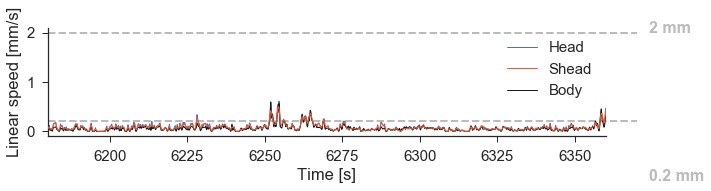

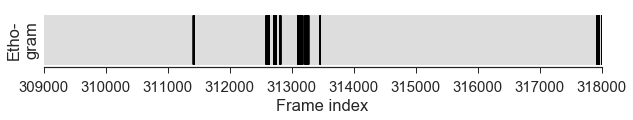

In [22]:
tims = 1
start = 300000 + tims * 9000
end = 300000 + (tims+1) * 9000

## arange time as a vector
dt = 0.02
time = np.arange(start*dt,(end+1)*dt,dt)[:-1]
print(time.shape, (end+1)*dt, time[-1])
## new figure
plt.figure(figsize=(10,2))
## plotting data for head speeds as blue solid line
plt.plot(time, speeds.loc[start:end,'head'], 'b-', lw=1, label='Head')
## plotting data for head speeds as blue solid line
plt.plot(time, speeds.loc[start:end,'smoother_head'], '-', c="#ff5522", lw=1, label='Shead', zorder=10)
## plotting data for body speeds as black solid line
plt.plot(time, speeds.loc[start:end,'body'], 'k-', lw=1, label='Body')
## add legend
plt.legend()
## lines annotation
plt.hlines(2, time[0], time[-1]+10, colors='#bbbbbb', linestyles='--', lw=2, clip_on=False)
plt.hlines(0.2, time[0], time[-1]+10, colors='#bbbbbb', linestyles='--', lw=2, clip_on=False)
plt.text(time[-1]+14, 2, "2 mm", color='#bbbbbb', fontsize=16, fontweight='bold')
plt.text(time[-1]+14, -1, "0.2 mm", color='#bbbbbb', fontsize=16, fontweight='bold')
## axes labels
plt.xlabel("Time [s]")
plt.ylabel("Linear speed [mm/s]")
plt.xlim([time[0],time[-1]])
#plt.ylim([0,20])
## despined axes looks nicer
sns.despine()

ax = plot_etho(etho_vector, lims=[start, end])